In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import queue
import math
np.set_printoptions(precision=5,linewidth=120,suppress=True)

# the bisect module enables to easily keep an ordered list
# cf. https://docs.python.org/3.7/library/bisect.html
# useful for maintaining the OPEN list
import bisect

In [2]:
def heuristics_distance(node, n):
    """this function is computes the heuristic used in A*"""
    i, j = convert_to_matrixindex(node, n)
    gi, gj = convert_to_matrixindex(n*n-1, n)
    return math.fabs(i - gi) + math.fabs(j - gj)

def heuristics_zero(node, n):
    """for the case where the heuristic is 0"""
    return 0

In [3]:
def depthFirstSearch(graph, start_node, end_node, cost):
    """
    this function gets a graph, a start_node, end_node and cost list as entry
    and returns a path (list of nodes) as output
    it return an empty list in case of failure
    
    it follows the depth-first search strategy
    """

    visited_node= []
    open_set = [start_node]
    estimated_total_cost = np.inf
    past_cost = np.ones(len(graph)) * np.inf
    past_cost[start_node] = 0
    parent = [-1] * (len(graph))
    while open_set:
        current = open_set.pop(0)
        visited_node.append(current)
        for child in graph[current]:
            tmp_cost = past_cost[current] + cost[current,child]
            if tmp_cost < np.min([past_cost[child], estimated_total_cost]):
                past_cost[child] = tmp_cost
                parent[child] = current
                if child != end_node and child not in open_set:
                    open_set.insert(0,child)
                else:
                    estimated_total_cost = tmp_cost
    if np.isinf(estimated_total_cost):
        print('Failure')
        return []
    
    print('Success')
    path = []
    current = end_node
    while current!= start_node:
        path.append(current)
        current = parent[current]
    path.append(current)
    print('cost = ' + str(past_cost[int(end_node)]))
    return path, len(visited_node)

def breadthFirstSearch(graph, start_node, end_node, cost):
    """
    this function gets a graph, a start_node, end_node and cost list as entry
    and returns a path (list of nodes) as output
    it return an empty list in case of failure
    
    it follows the breadth first search strategy
    """

    visited_node= []
    open_set = [start_node]
    estimated_total_cost = np.inf
    past_cost = np.ones(len(graph)) * np.inf
    past_cost[start_node] = 0
    parent = [-1] * (len(graph))
    while open_set:
        current = open_set.pop(0)
        visited_node.append(current)
        for child in graph[current]:
            tmp_cost = past_cost[current] + cost[current,child]
            if tmp_cost < np.min([past_cost[child], estimated_total_cost]):
                past_cost[child] = tmp_cost
                parent[child] = current
                if child != end_node and child not in open_set:
                    open_set.append(child)
                else:
                    estimated_total_cost = tmp_cost
    if np.isinf(estimated_total_cost):
        print('Failure')
        return []
    
    print('Success')
    path = []
    current = end_node
    while current!= start_node:
        path.append(current)
        current = parent[current]
    path.append(current)
    print('cost = ' + str(past_cost[int(end_node)]))
    return path, visited_node
   


def AStar(graph, start_node, end_node, cost, heuristic):
    """
    this function gets a graph, a start_node, end_node and cost list as entry
    and returns a path (list of nodes) as output
    it return an empty list in case of failure
    
    it follows the A* algorithm seen in class
    """
    
    # we initialize the algorithm
    open_set = [start_node]
    estimated_total_cost = [0]
    closed_set = []
    past_cost = np.ones(len(graph)) * np.inf
    past_cost[start_node] = 0
    parent = [-1] * (len(graph))
    count = 0
    while open_set:
        count += 1
        current = open_set.pop(0)
        estimated_total_cost.pop(0)
        closed_set.append(current)
        if current == end_node:
            print('success')
            path = []
            while current!= start_node:
                path.append(current)
                current = parent[current]
            path.append(current)
            print('cost = ' + str(past_cost[int(end_node)]))
            return path, count
        for child in graph[current]:
            if child not in closed_set:
                tentative_past_cost = past_cost[current] + cost[current,child]
                if tentative_past_cost < past_cost[child]:
                    past_cost[child] = tentative_past_cost
                    parent[child] = current
                    est = past_cost[child]
                    if child != end_node:
                        est = est + heuristic(child, int(math.sqrt(len(graph))) ) #+heuristic cost to go
                    if child in open_set:
                        s = open_set.index(child)
                        open_set.pop(s)
                        estimated_total_cost.pop(s)
                    index = bisect.bisect(estimated_total_cost, est)
                    open_set.insert(index, child)
                    estimated_total_cost.insert(index, est)
    print('Failure')
    return [], count

In [4]:
def display_result(world_mat, path):
    """
    This function displays a maze described in world_mat and a path inside the maze
    world_mat: a NxN matrix that contains the maze (0 for free path, -10 for obstacle)
    path: a list of elements numbered as the graph (i.e. from 0 to N**2-1)
    """
    N = world_mat.shape[0]
    display_mat = world_mat.copy()
    for el in path:
        display_mat[convert_to_matrixindex(el,N)] = 5
    plt.matshow(display_mat, cmap='Greys')
    
def convert_to_listindex(i,j,N):
    """
    This function converts a (i,j) matrix entry index to a list index for matrix of size N
    """
    return N*i+j

def convert_to_matrixindex(a,N):
    """
    This function converts a list entry a into a (i,j) matrix entry for matrix of size N
    """
    i = int(a/N) # the result of integer division
    j = int(a%N) # the  remainder of the division
    return i,j

def create_graph(world_mat):
    """
    This functions takes a NxN matrix in entry and creates a graph and a map of costs
    Since we use lists, for a world_mat of size NxN, we associate to the entry [i,j] of world_map
    the index a=N*i + j of the list
    output:
        graph: a list of neighbors  (indexed as explained above)
        cost: a N**2 x  N**2 array. Each entry cost[i,j] contains the cost of transitioning from node i to node j
            it is infinite if there is no edge from i to j
    """
    N = world_mat.shape[0]
    graph = []
    for i in range(N):
        for j in range(N):
            neigh = []
            if(i!=N-1):
                if(world_mat[i+1,j]==0):
                    neigh.append(N*(i+1)+j)
            if(i!=0):
                if(world_mat[i-1,j]==0):
                    neigh.append(N*(i-1)+j)
            if(j!=N-1):
                if(world_mat[i,j+1]==0):
                    neigh.append(N*i+j+1)
            if(j!=0):
                if(world_mat[i,j-1]==0):
                    neigh.append(N*i+j-1)
            graph.append(neigh)
    
    cost = np.ones([N*N,N*N]) * np.inf
    
    for i in range(N*N):
        for j in graph[i]:
            cost[i,j] = 1
    
    return graph, cost

[[ 0.  0.  0.  0. 10.]
 [ 0. 10. 10.  0.  0.]
 [ 0. 10.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.]
 [ 0. 10. 10.  0.  0.]]


<IPython.core.display.Javascript object>


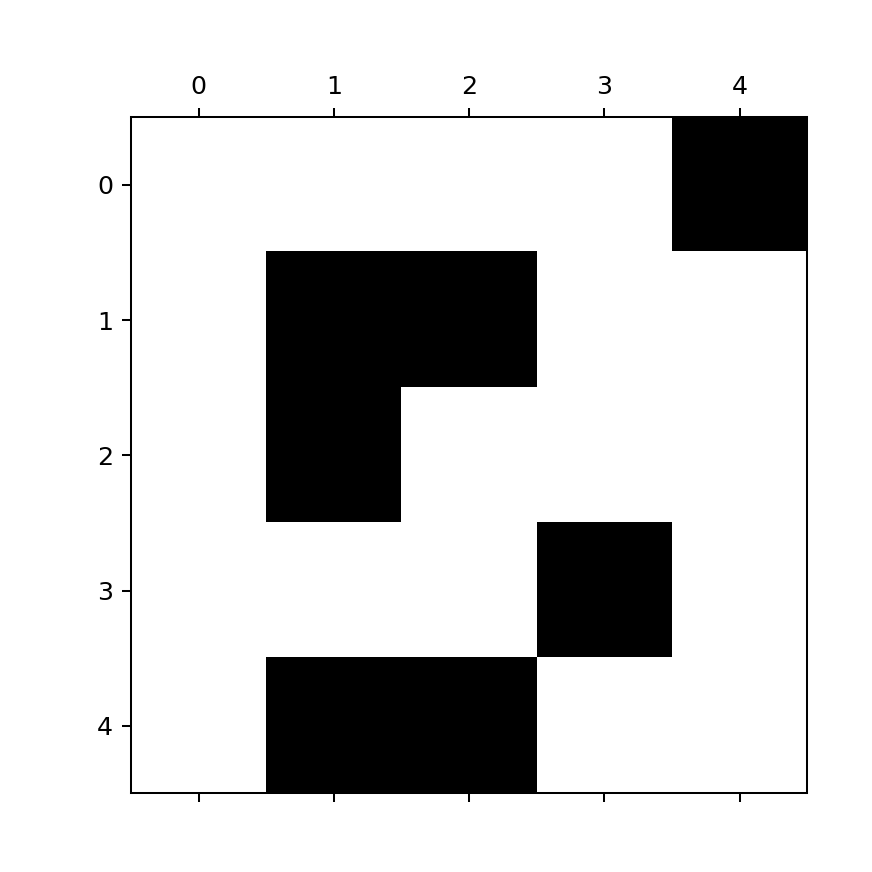

In [5]:
# let's create a map corresponding to the robot path planning example of lecture 3
# it is a 5x5 grid
world_map = np.zeros([5,5])
# and it contains obstacles which we mark as non 0
world_map[0,4] = 10
world_map[1,1:3] = 10
world_map[2,1] = 10
world_map[3,3] = 10
world_map[4,1:3] = 10

maze0 = world_map
# we can print the matrix
print(world_map)

# we can now display the result
display_result(world_map, [])

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 3)
(1, 4)
(2, 4)
(3, 4)
(4, 4)


<IPython.core.display.Javascript object>


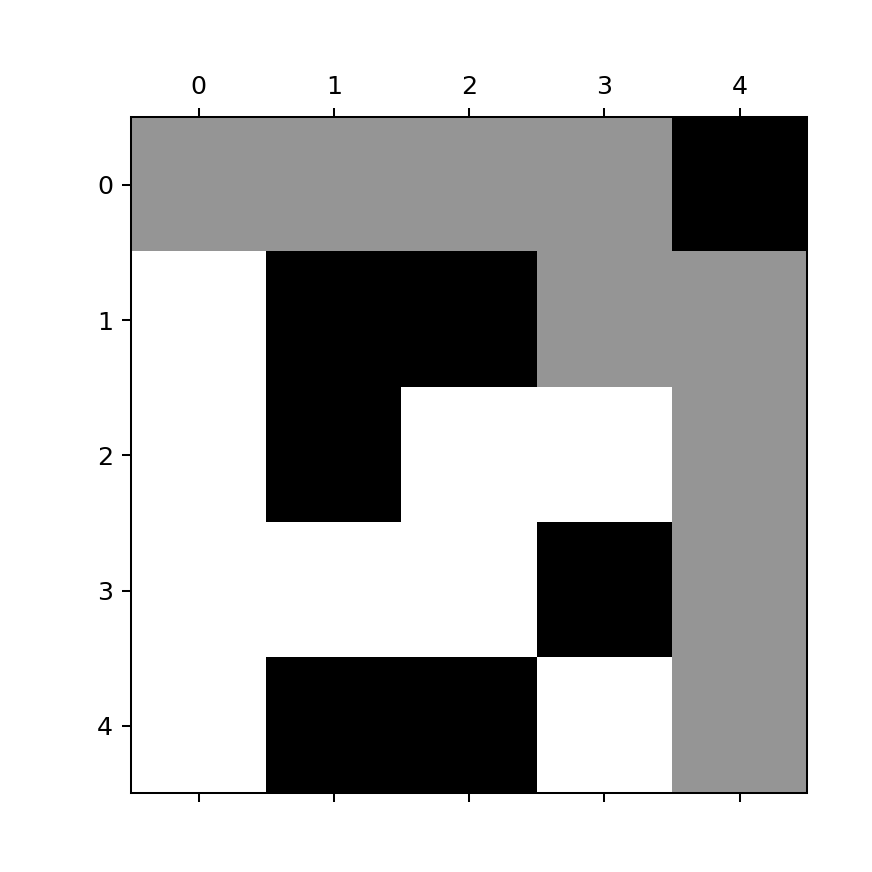

In [6]:
# let's assume we have a path from (0,0) to (4,4) that does (in linear index)
path = [0,1,2,3,8,9,14,19,24]

# we print the equivalent in matrix entries
for a in path:
    print(convert_to_matrixindex(a, 5))

# and we display it on the world grid (shown in grey)
display_result(world_map, path)


In [7]:
# we can also create the associated graph and costs
graph, cost = create_graph(world_map)

# the neighbors of entry the cell [0,0] are
print('Neighbors of entry [0,0]')
a = convert_to_listindex(0,0,5)
neighborhs = graph[a]
for n in neighborhs:
    print('in linear indexes: ' + str(n) + ' which corresponds to the matrix entry: ' + str(convert_to_matrixindex(n,5)))
    
print('\n\nNeighbors of entry [2,3]')
a = convert_to_listindex(2,3,5)
neighborhs = graph[a]
for n in neighborhs:
    print('in linear indexes: ' + str(n) + ' which corresponds to the matrix entry: ' + str(convert_to_matrixindex(n,5)))

Neighbors of entry [0,0]
in linear indexes: 5 which corresponds to the matrix entry: (1, 0)
in linear indexes: 1 which corresponds to the matrix entry: (0, 1)


Neighbors of entry [2,3]
in linear indexes: 8 which corresponds to the matrix entry: (1, 3)
in linear indexes: 14 which corresponds to the matrix entry: (2, 4)
in linear indexes: 12 which corresponds to the matrix entry: (2, 2)


<IPython.core.display.Javascript object>


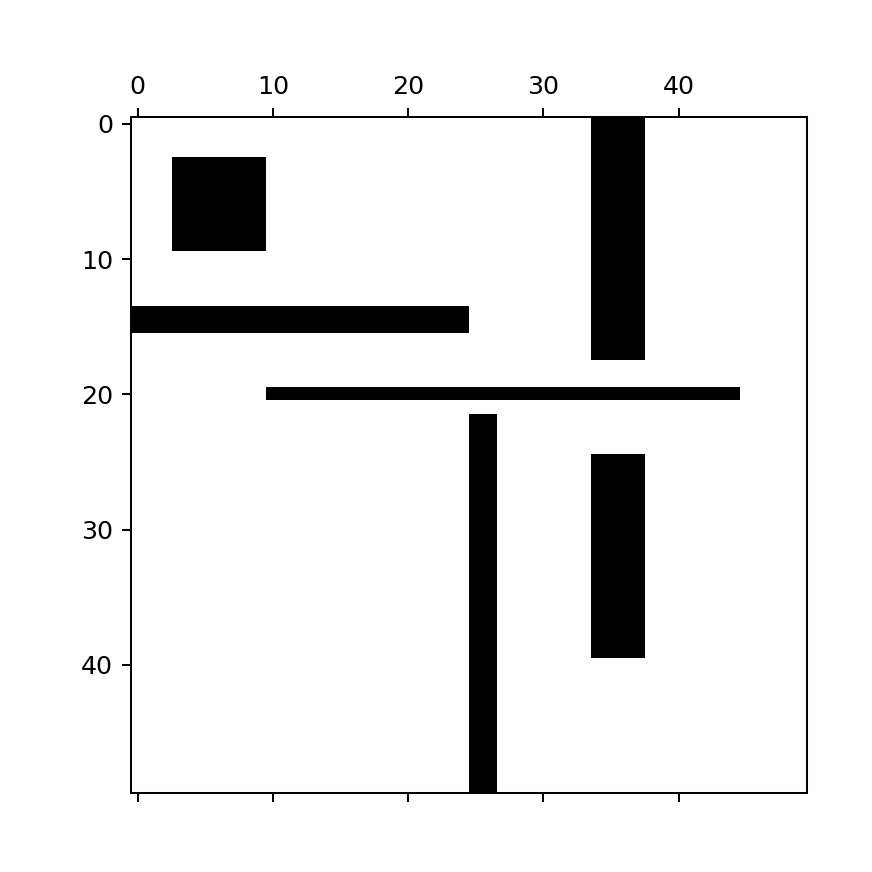

<IPython.core.display.Javascript object>


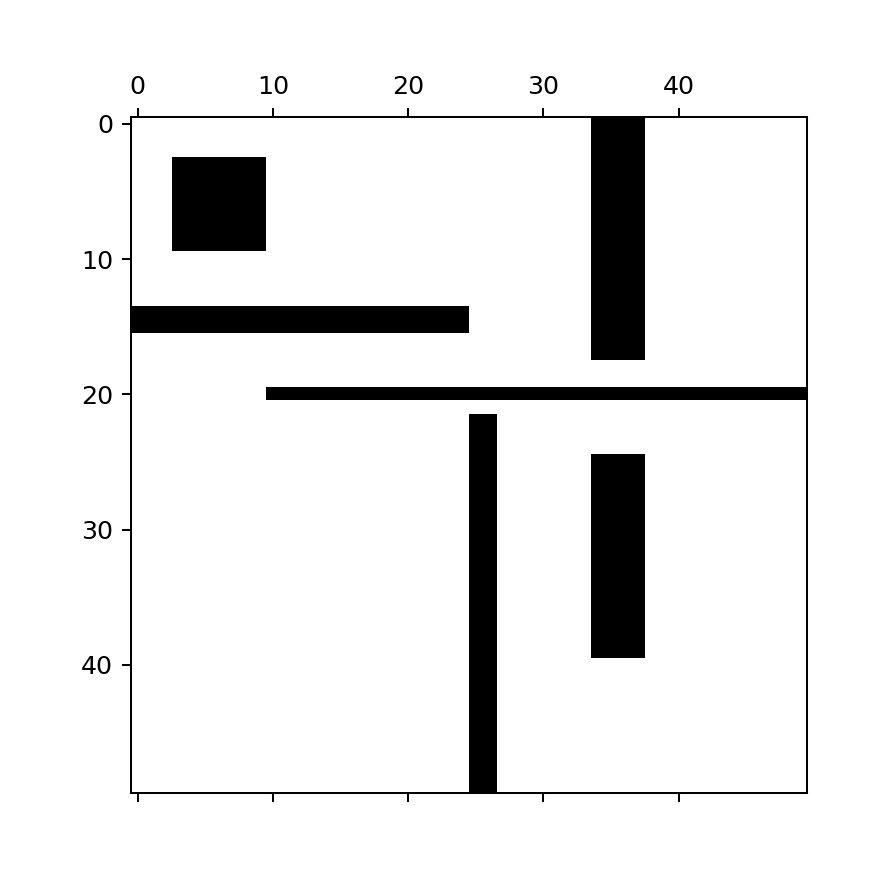

<IPython.core.display.Javascript object>


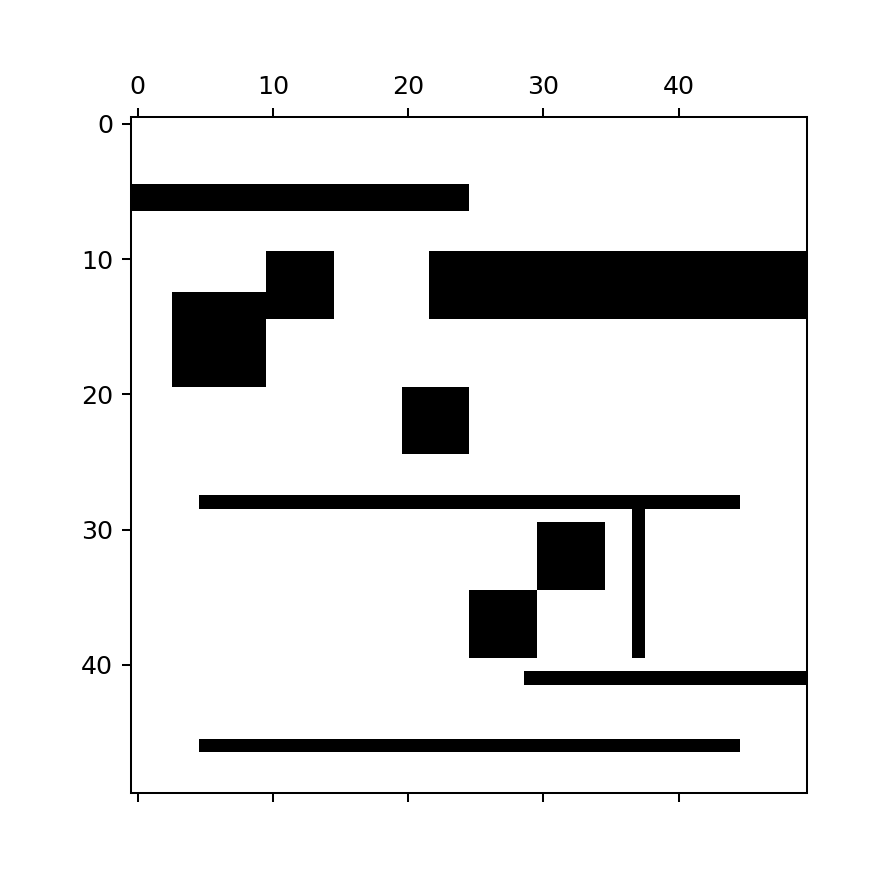

In [8]:
# here we load the 3 mazes and display them
maze1 = np.load('maze1.npy')
display_result(maze1, [])

maze2 = np.load('maze2.npy')
display_result(maze2, [])

maze3 = np.load('maze3.npy')
display_result(maze3, [])


## Part a

Success
cost = 8.0
The length of the path is 9
The algorithm tested 17 nodes before the shortest path was found


<IPython.core.display.Javascript object>


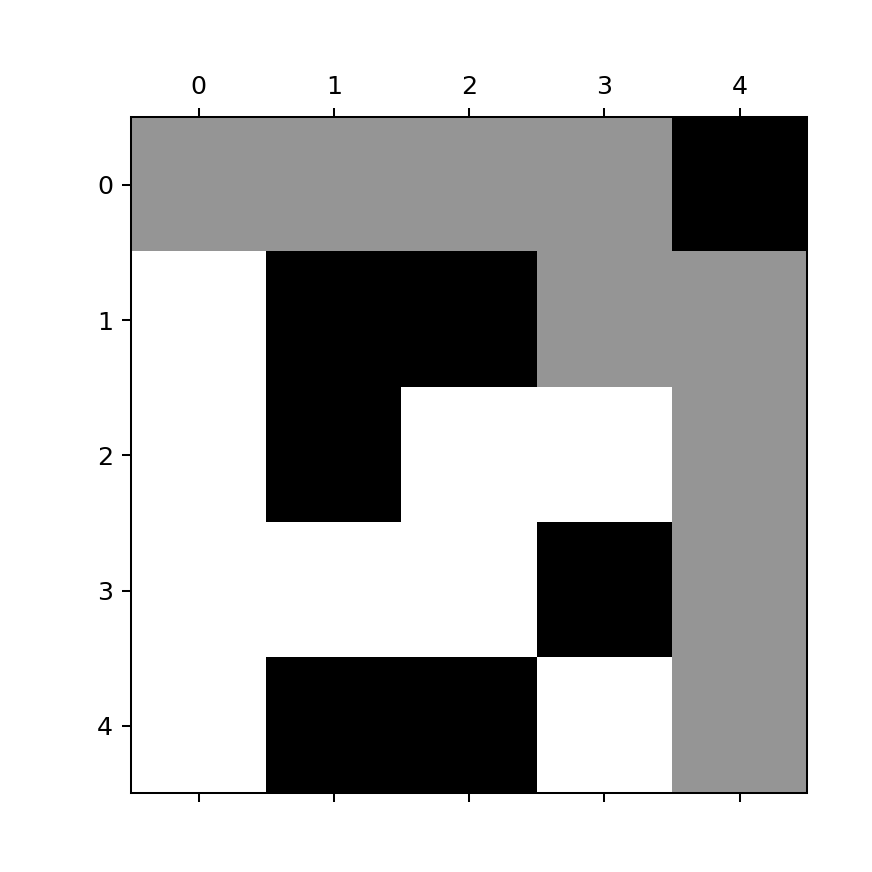

Success
cost = 98.0
The length of the path is 99
The algorithm tested 223241 nodes before the shortest path was found


<IPython.core.display.Javascript object>


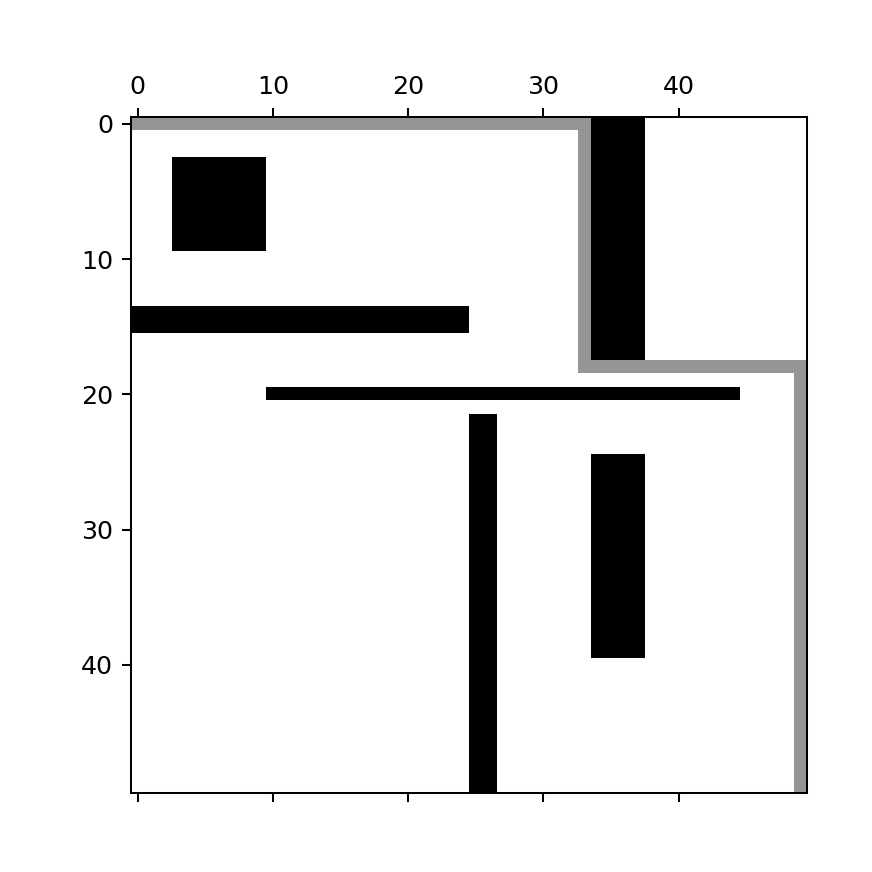

Success
cost = 130.0
The length of the path is 131
The algorithm tested 176721 nodes before the shortest path was found


<IPython.core.display.Javascript object>


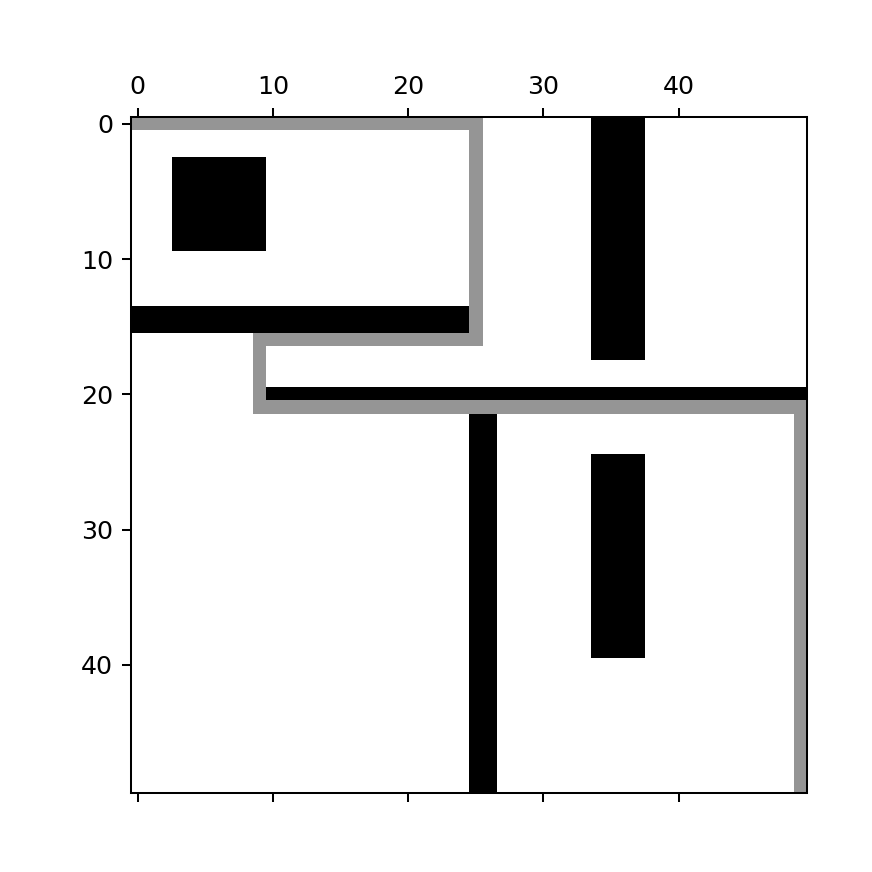

Success
cost = 140.0
The length of the path is 141
The algorithm tested 332734 nodes before the shortest path was found


<IPython.core.display.Javascript object>


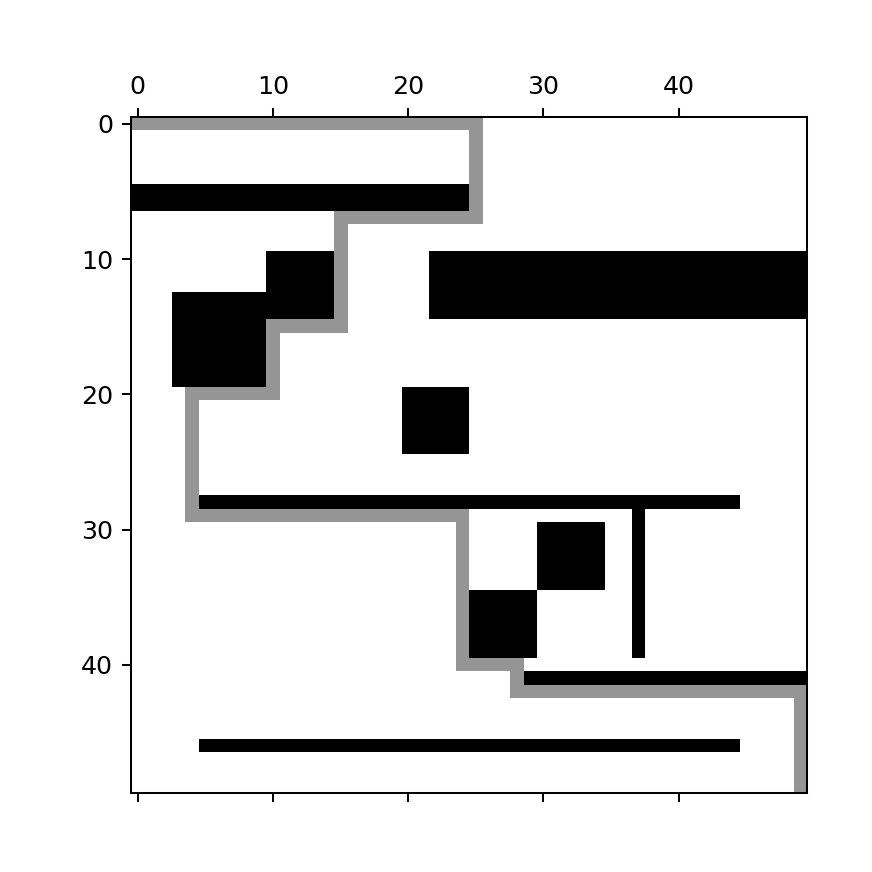

In [9]:

# Part a: DFS

# Maze0
N = 5

graph, cost = create_graph(maze0)

path, count = depthFirstSearch(graph,0,N*N-1,cost)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze0, path)
#print(path)

# Maze1
N = 50

graph, cost = create_graph(maze1)

path, count = depthFirstSearch(graph,0,N*N-1,cost)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze1, path)
#print(path)

#Maze2
N = 50

graph, cost = create_graph(maze2)

path, count = depthFirstSearch(graph,0,N*N-1,cost)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze2, path)
#print(path)

# Maze3
N = 50

graph, cost = create_graph(maze3)

path, count = depthFirstSearch(graph,0,N*N-1,cost)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze3, path)
#print(path)

## Part b

Success
cost = 8.0
The length of the path is 9
The algorithm tested [0, 5, 1, 10, 2, 15, 3, 20, 16, 8, 17, 13, 9, 12, 14, 19] nodes before the shortest path was found


<IPython.core.display.Javascript object>


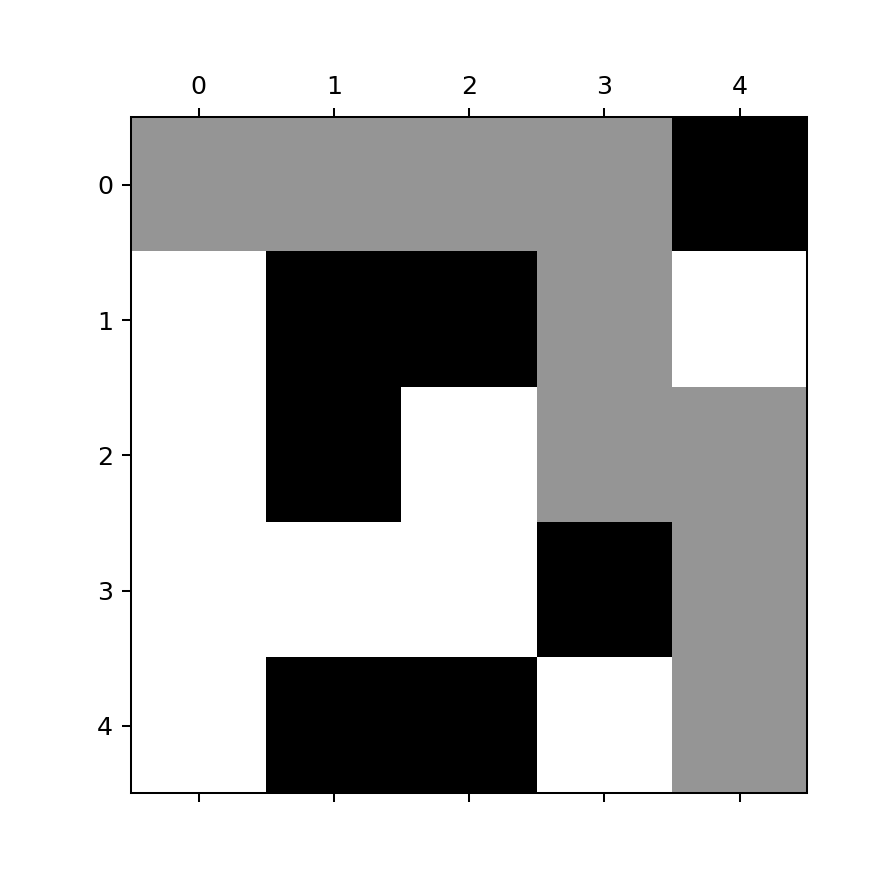

Success
cost = 98.0
The length of the path is 99
The algorithm tested [0, 50, 1, 100, 51, 2, 150, 101, 52, 3, 200, 151, 102, 53, 4, 250, 201, 152, 103, 54, 5, 300, 251, 202, 104, 55, 6, 350, 301, 252, 105, 56, 7, 400, 351, 302, 106, 57, 8, 450, 401, 352, 107, 58, 9, 500, 451, 402, 108, 59, 10, 550, 501, 452, 109, 60, 11, 600, 551, 502, 110, 61, 12, 650, 601, 552, 503, 160, 111, 62, 13, 651, 602, 553, 504, 210, 161, 112, 63, 14, 652, 603, 554, 505, 260, 211, 162, 113, 64, 15, 653, 604, 555, 506, 310, 261, 212, 163, 114, 65, 16, 654, 605, 556, 507, 360, 311, 262, 213, 164, 115, 66, 17, 655, 606, 557, 508, 410, 361, 312, 263, 214, 165, 116, 67, 18, 656, 607, 558, 509, 460, 411, 362, 313, 264, 215, 166, 117, 68, 19, 657, 608, 559, 510, 461, 412, 363, 314, 265, 216, 167, 118, 69, 20, 658, 609, 560, 511, 462, 413, 364, 315, 266, 217, 168, 119, 70, 21, 659, 610, 561, 512, 463, 414, 365, 316, 267, 218, 169, 120, 71, 22, 660, 611, 562, 513, 464, 415, 366, 317, 268, 219, 170, 121, 72, 23, 661, 6

<IPython.core.display.Javascript object>


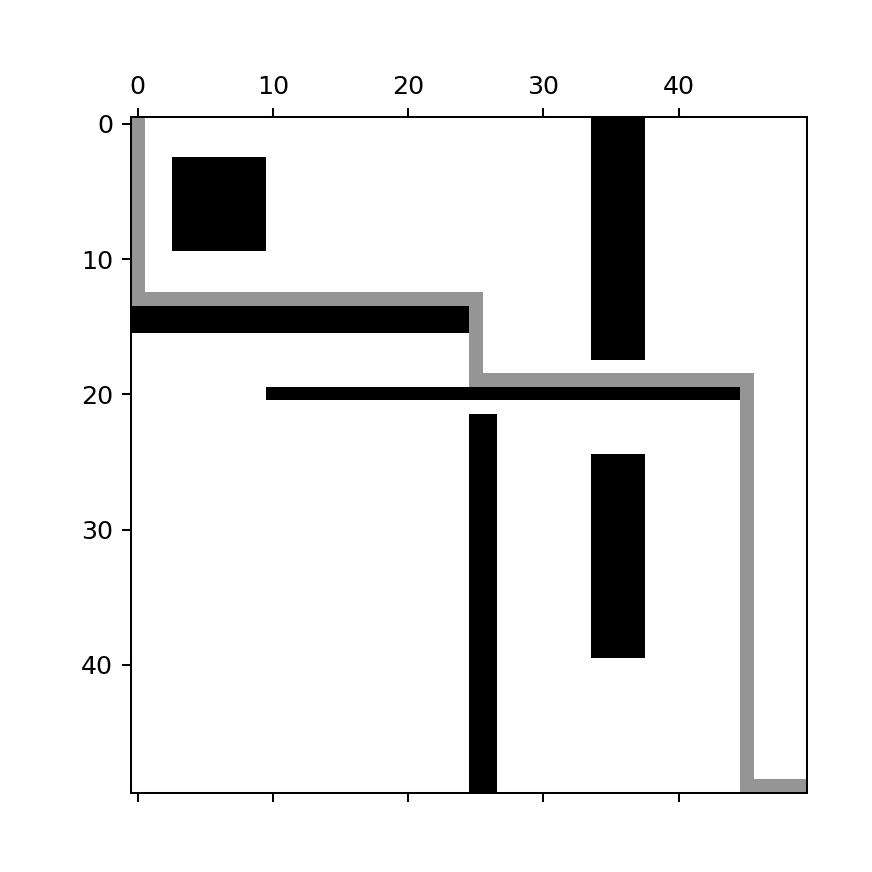

Success
cost = 130.0
The length of the path is 131
The algorithm tested [0, 50, 1, 100, 51, 2, 150, 101, 52, 3, 200, 151, 102, 53, 4, 250, 201, 152, 103, 54, 5, 300, 251, 202, 104, 55, 6, 350, 301, 252, 105, 56, 7, 400, 351, 302, 106, 57, 8, 450, 401, 352, 107, 58, 9, 500, 451, 402, 108, 59, 10, 550, 501, 452, 109, 60, 11, 600, 551, 502, 110, 61, 12, 650, 601, 552, 503, 160, 111, 62, 13, 651, 602, 553, 504, 210, 161, 112, 63, 14, 652, 603, 554, 505, 260, 211, 162, 113, 64, 15, 653, 604, 555, 506, 310, 261, 212, 163, 114, 65, 16, 654, 605, 556, 507, 360, 311, 262, 213, 164, 115, 66, 17, 655, 606, 557, 508, 410, 361, 312, 263, 214, 165, 116, 67, 18, 656, 607, 558, 509, 460, 411, 362, 313, 264, 215, 166, 117, 68, 19, 657, 608, 559, 510, 461, 412, 363, 314, 265, 216, 167, 118, 69, 20, 658, 609, 560, 511, 462, 413, 364, 315, 266, 217, 168, 119, 70, 21, 659, 610, 561, 512, 463, 414, 365, 316, 267, 218, 169, 120, 71, 22, 660, 611, 562, 513, 464, 415, 366, 317, 268, 219, 170, 121, 72, 23, 661,

<IPython.core.display.Javascript object>


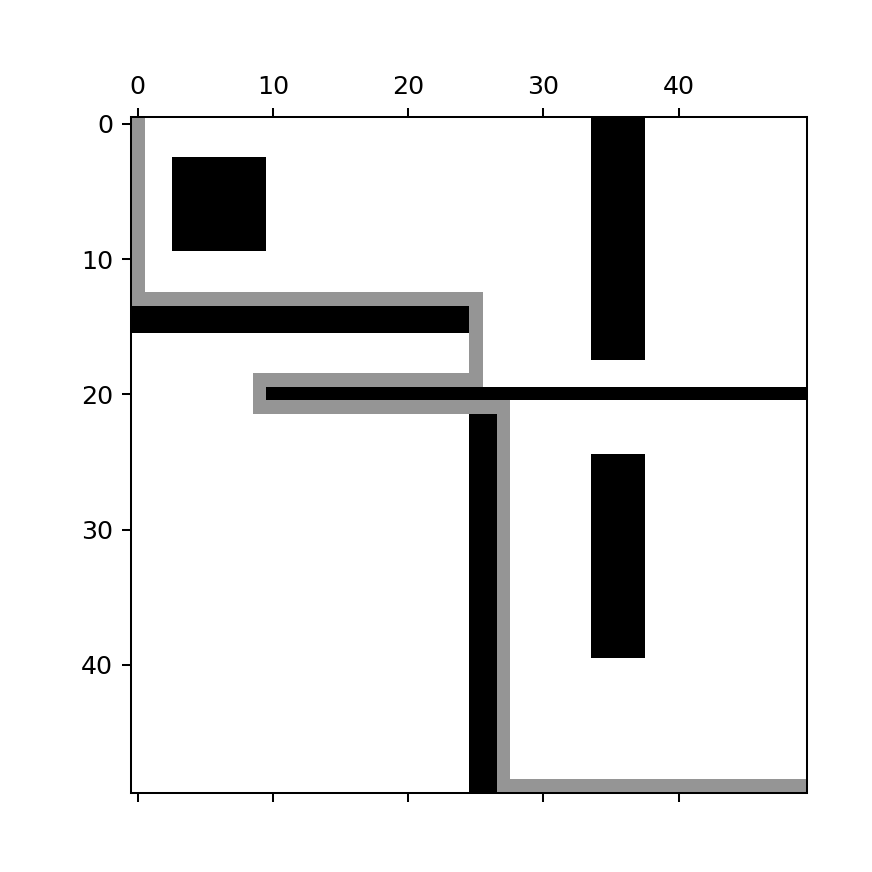

Success
cost = 140.0
The length of the path is 141
The algorithm tested [0, 50, 1, 100, 51, 2, 150, 101, 52, 3, 200, 151, 102, 53, 4, 201, 152, 103, 54, 5, 202, 153, 104, 55, 6, 203, 154, 105, 56, 7, 204, 155, 106, 57, 8, 205, 156, 107, 58, 9, 206, 157, 108, 59, 10, 207, 158, 109, 60, 11, 208, 159, 110, 61, 12, 209, 160, 111, 62, 13, 210, 161, 112, 63, 14, 211, 162, 113, 64, 15, 212, 163, 114, 65, 16, 213, 164, 115, 66, 17, 214, 165, 116, 67, 18, 215, 166, 117, 68, 19, 216, 167, 118, 69, 20, 217, 168, 119, 70, 21, 218, 169, 120, 71, 22, 219, 170, 121, 72, 23, 220, 171, 122, 73, 24, 221, 172, 123, 74, 25, 222, 173, 124, 75, 26, 223, 174, 125, 76, 27, 224, 175, 126, 77, 28, 225, 176, 127, 78, 29, 275, 226, 177, 128, 79, 30, 325, 276, 227, 178, 129, 80, 31, 375, 326, 277, 228, 179, 130, 81, 32, 425, 376, 374, 327, 278, 229, 180, 131, 82, 33, 475, 426, 424, 377, 373, 328, 279, 230, 181, 132, 83, 34, 476, 474, 427, 423, 378, 372, 329, 280, 231, 182, 133, 84, 35, 477, 473, 428, 422, 379, 371

<IPython.core.display.Javascript object>


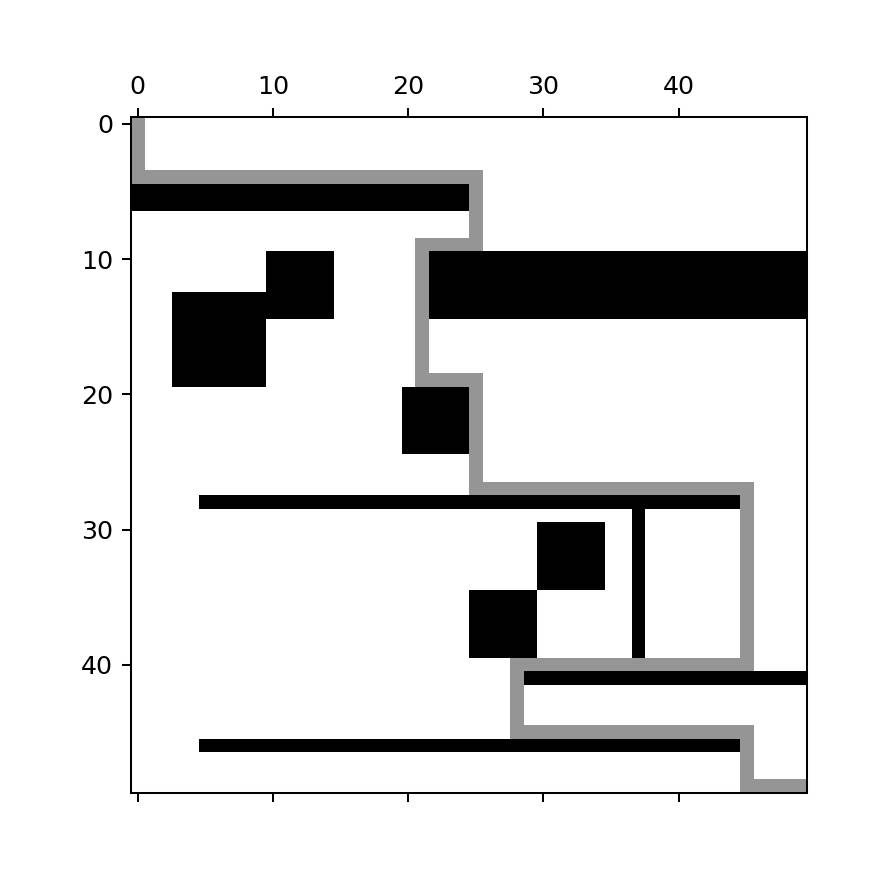

In [10]:
# Part b: BFS


# Maze0
N = 5

graph, cost = create_graph(maze0)

path, count = breadthFirstSearch(graph,0,N*N-1,cost)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze0, path)
#print(path)

# Maze1
N = 50

graph, cost = create_graph(maze1)
    
path, count = breadthFirstSearch(graph,0,N*N-1,cost)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze1, path)
#print(path)

#Maze2
N = 50

graph, cost = create_graph(maze2)

path, count = breadthFirstSearch(graph,0,N*N-1,cost)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze2, path)
#print(path)

# Maze3
N = 50

graph, cost = create_graph(maze3)

path, count = breadthFirstSearch(graph,0,N*N-1,cost)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze3, path)
#print(path)

## Part c

success
cost = 8.0
The length of the path is 9
The algorithm tested 17 nodes before the shortest path was found


<IPython.core.display.Javascript object>


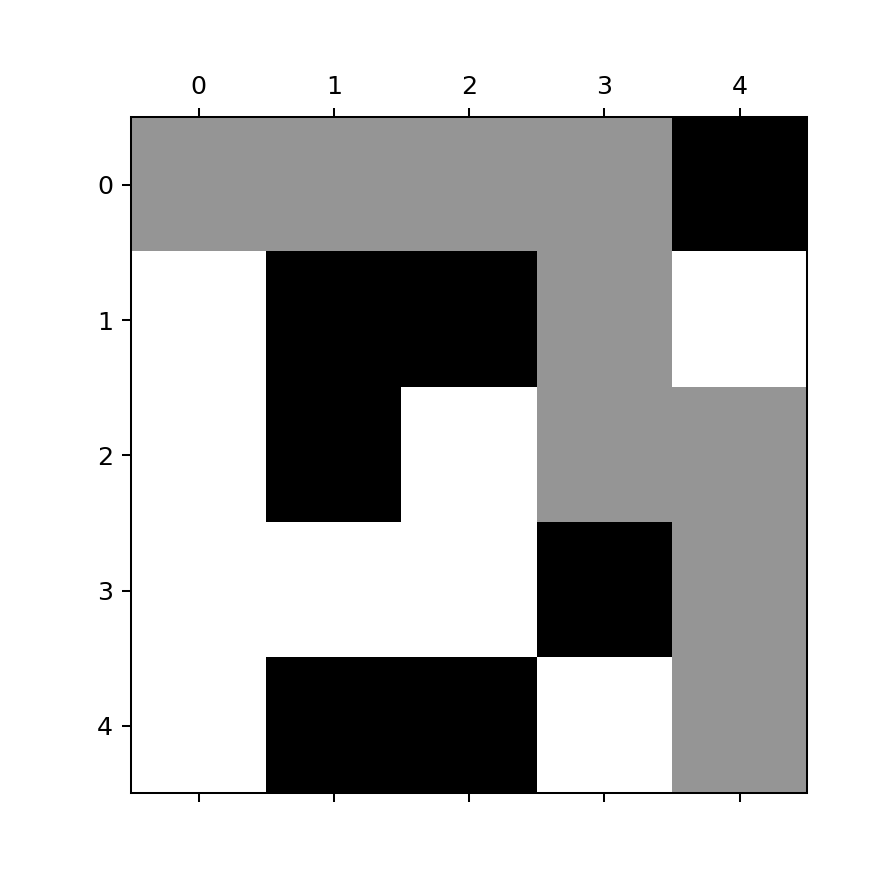

success
cost = 98.0
The length of the path is 99
The algorithm tested 2025 nodes before the shortest path was found


<IPython.core.display.Javascript object>


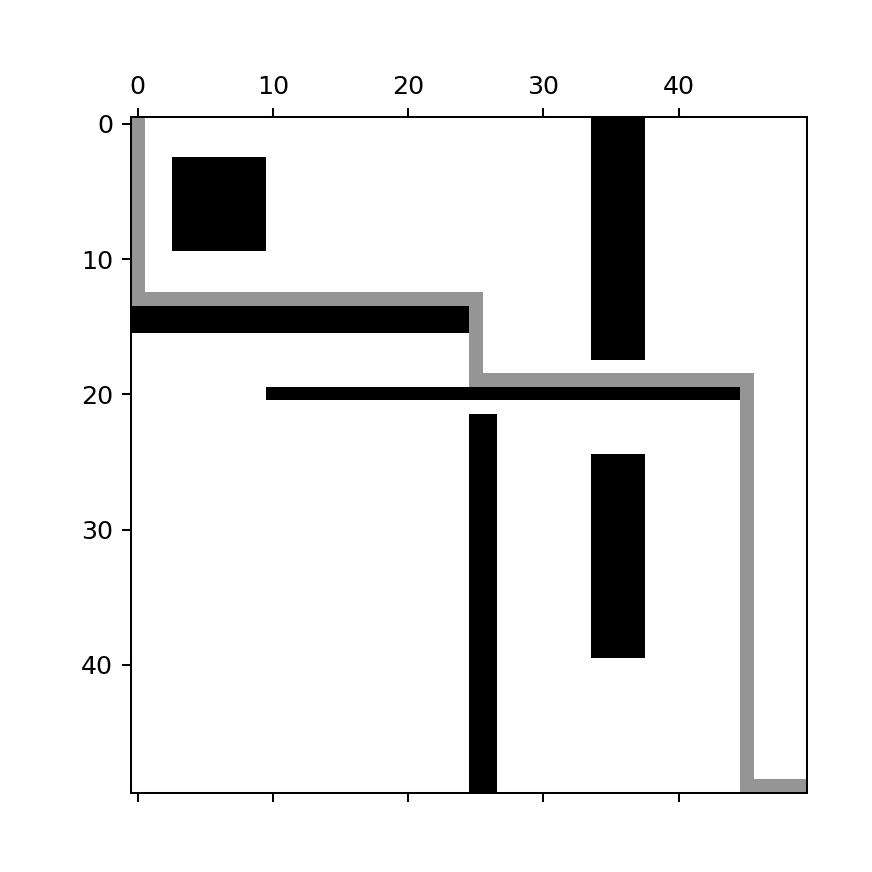

success
cost = 130.0
The length of the path is 131
The algorithm tested 2173 nodes before the shortest path was found


<IPython.core.display.Javascript object>


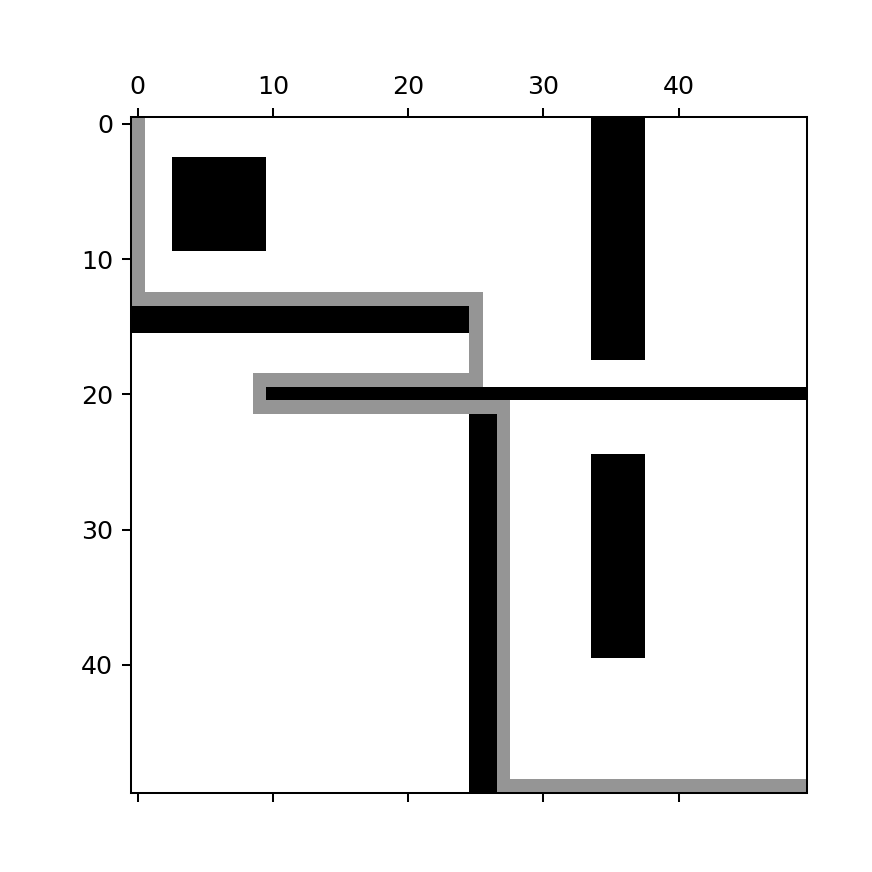

success
cost = 140.0
The length of the path is 141
The algorithm tested 2049 nodes before the shortest path was found


<IPython.core.display.Javascript object>


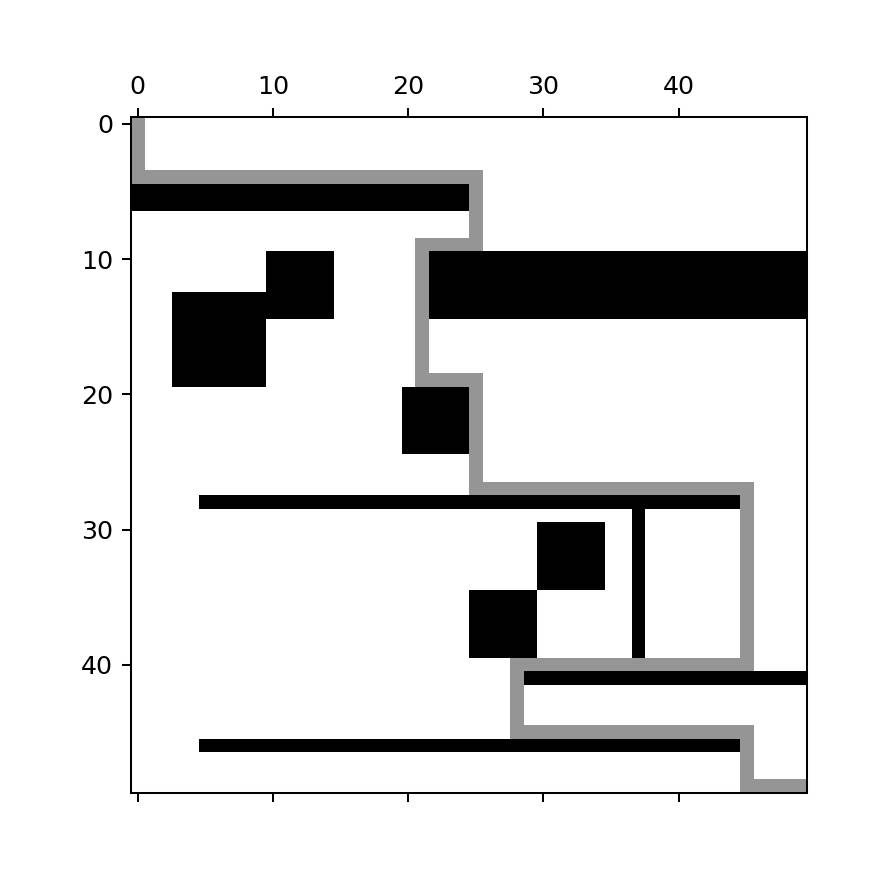

In [11]:
# Part c: Astar zero heuristic

# Maze0
N = 5

graph, cost = create_graph(maze0)

path, count = AStar(graph,0,N*N-1,cost, heuristics_zero)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze0, path)
#print(path)

# Maze1
N = 50

graph, cost = create_graph(maze1)

path, count = AStar(graph,0,N*N-1,cost, heuristics_zero)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze1, path)
#print(path)

#Maze2
N = 50

graph, cost = create_graph(maze2)

path, count = AStar(graph,0,N*N-1,cost, heuristics_zero)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze2, path)
#print(path)

# Maze3
N = 50

graph, cost = create_graph(maze3)

path, count = AStar(graph,0,N*N-1,cost, heuristics_zero)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze3, path)
#print(path)

success
cost = 8.0
The length of the path is 9
The algorithm tested 16 nodes before the shortest path was found


<IPython.core.display.Javascript object>


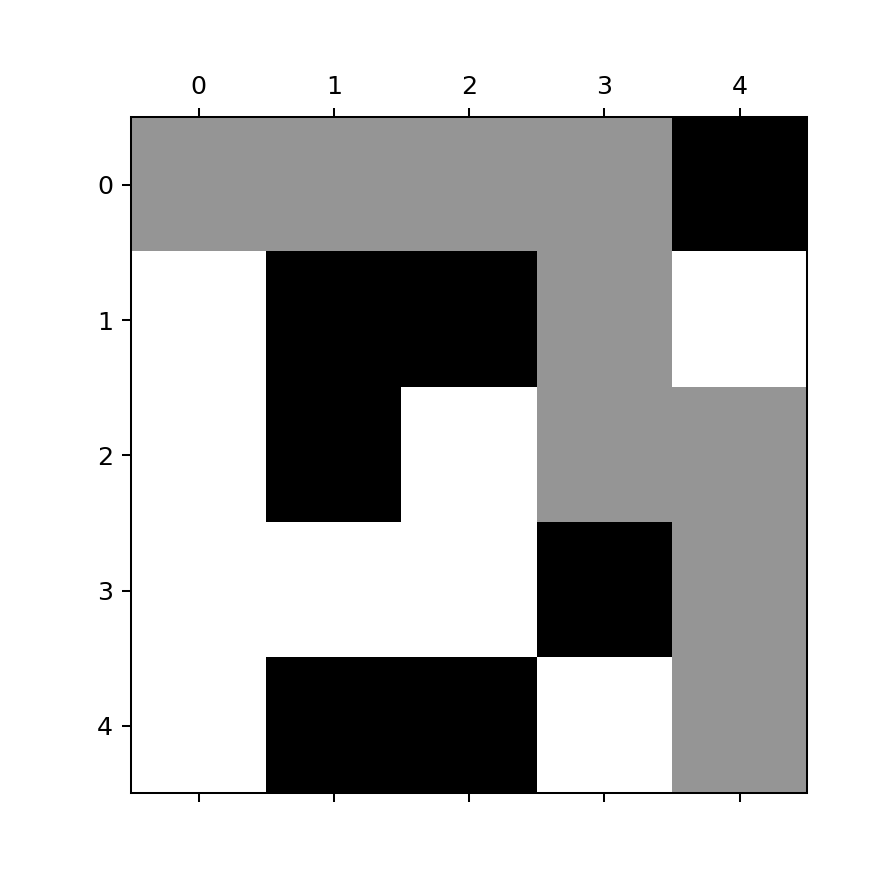

success
cost = 98.0
The length of the path is 99
The algorithm tested 663 nodes before the shortest path was found


<IPython.core.display.Javascript object>


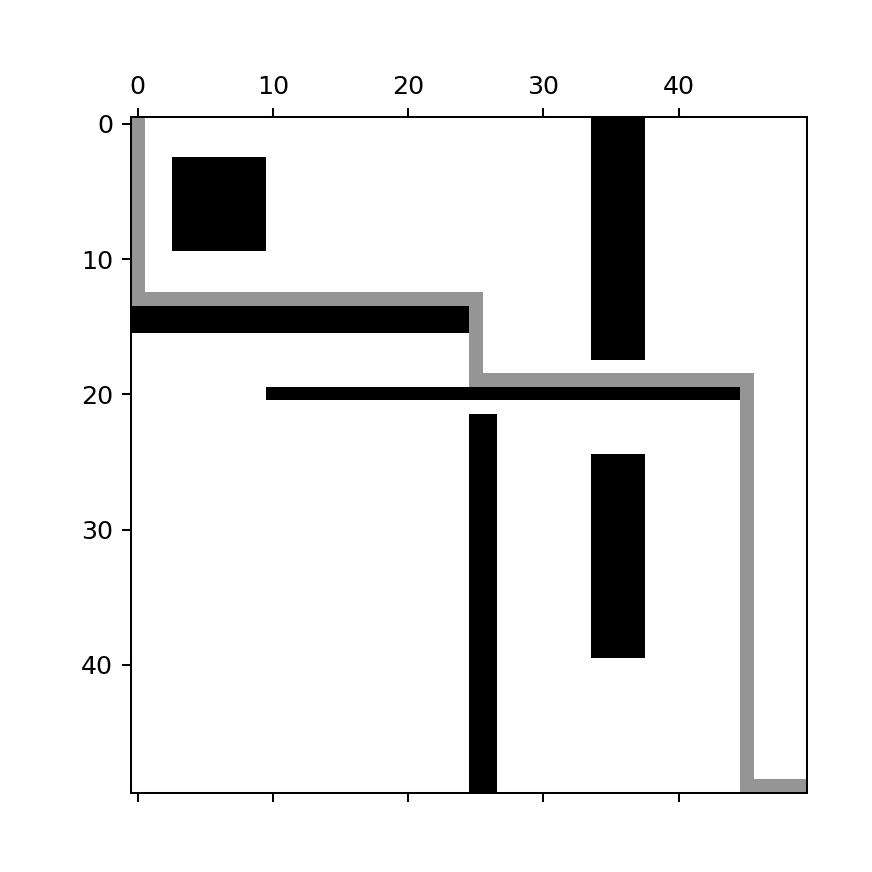

success
cost = 130.0
The length of the path is 131
The algorithm tested 1843 nodes before the shortest path was found


<IPython.core.display.Javascript object>


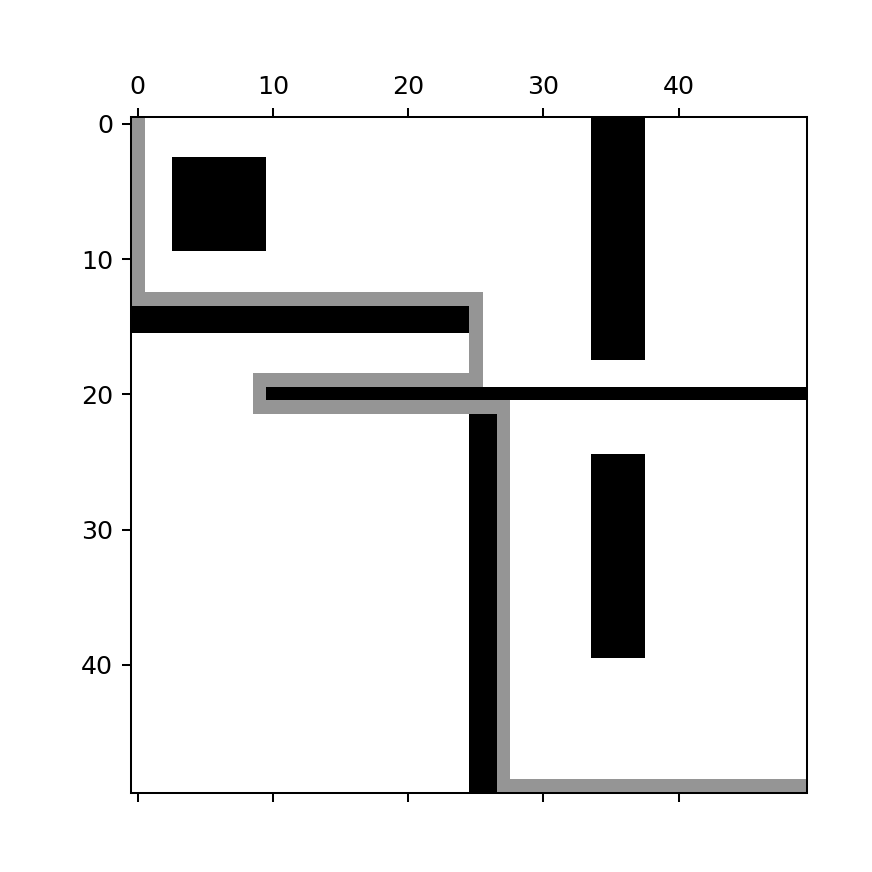

success
cost = 140.0
The length of the path is 141
The algorithm tested 1703 nodes before the shortest path was found


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


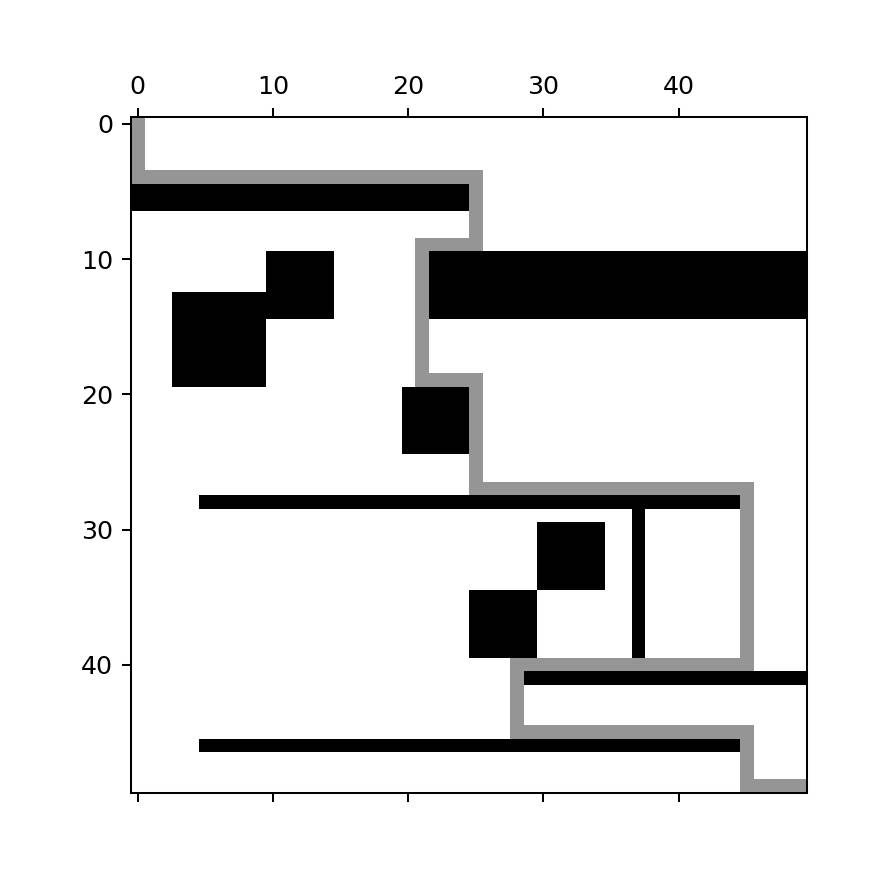

In [12]:
# Part c: Astar distance

# Maze0
N = 5

graph, cost = create_graph(maze0)

path, count = AStar(graph,0,N*N-1,cost, heuristics_distance)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze0, path)
#print(path)

# Maze1
N = 50

graph, cost = create_graph(maze1)

path, count = AStar(graph,0,N*N-1,cost, heuristics_distance)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze1, path)
#print(path)

#Maze2
N = 50

graph, cost = create_graph(maze2)

path, count = AStar(graph,0,N*N-1,cost, heuristics_distance)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze2, path)
#print(path)

# Maze3
N = 50

graph, cost = create_graph(maze3)

path, count = AStar(graph,0,N*N-1,cost, heuristics_distance)
print('The length of the path is {}'.format(len(path)))
print('The algorithm tested {} nodes before the shortest path was found'.format(count))

display_result(maze3, path)
#print(path)

### For the A* algorithm, both the Manhattan distance and 0 are under-estimators of the actual cost. For the 0 heuristic, it is obvious because the cost-to-go cannot be smaller than 0. For the Manhattan distance, it is also the case because it is the shortest path without obstacles, therefore the cost-to-go cannot be smaller.

## Part d

### Pros and Cons: While they all find the optimal path: DFS needs to go through a lot of nodes to find the optimal path (it is very slow); BFS finds the path much faster than DFS; A* Zero finds the path at a similar number of nodes comparing to BFS; A* Distance finds the path faster than all above methods because it has a good prediction of the cost-to-go.